# Evaluate the data with the backend
We are evaluating the gpt integration by simulating student responses from previous real data and comparing the feedback and results with real human grading.

## Load and Prepare Data

In [2]:
import pandas as pd

In [3]:
tasks_df = pd.read_csv('data/tasks_df.csv')
submissions_df = pd.read_csv('data/submissions_df.csv')
users_df = pd.read_csv('data/users_df.csv')

print("---Tasks---")
print(tasks_df.head())
print("---Submissions---")
print(submissions_df.head())
print("---Users---")
print(users_df.head())

---Tasks---
    id            slug  assignment_id  max_points  solution_file_id  \
0  402  1_week1_sta120            302         1.0               606   
1  403  2_week1_sta120            302         1.0               611   
2  753  2_week8_sta120            652         1.0              1261   
3  709  3_week6_sta120            603         1.0              1146   
4  404  3_week1_sta120            302         1.0               617   

  solution_file_name solution_file_mime_type  \
0           script.R              text/plain   
1           script.R              text/plain   
2           script.R              text/plain   
3           script.R              text/plain   
4           script.R              text/plain   

                                            solution  instruction_file_id  \
0  png(file = "solution.png")\nrequire(fields) # ...                  602   
1                                 demo(persp) \n\n\n                  607   
2   png(file="solution.png")\nmu <- c(1, 

### Stratified Sampling

Total sampled submissions (Stat): 200
Total unique exercises (Stat): 10
Total sampled submissions (Mat): 200
Total unique exercises (Mat): 10


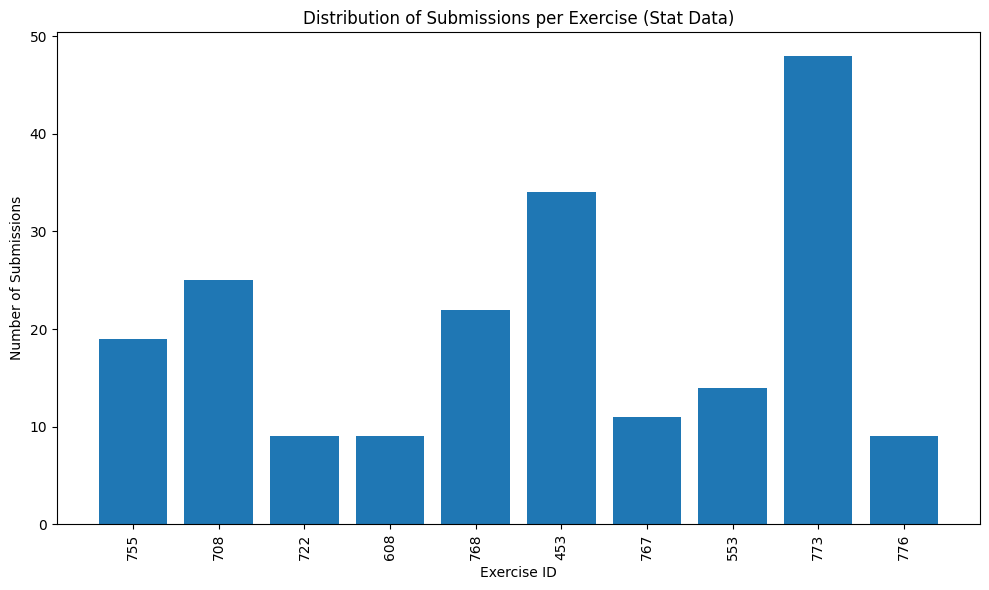

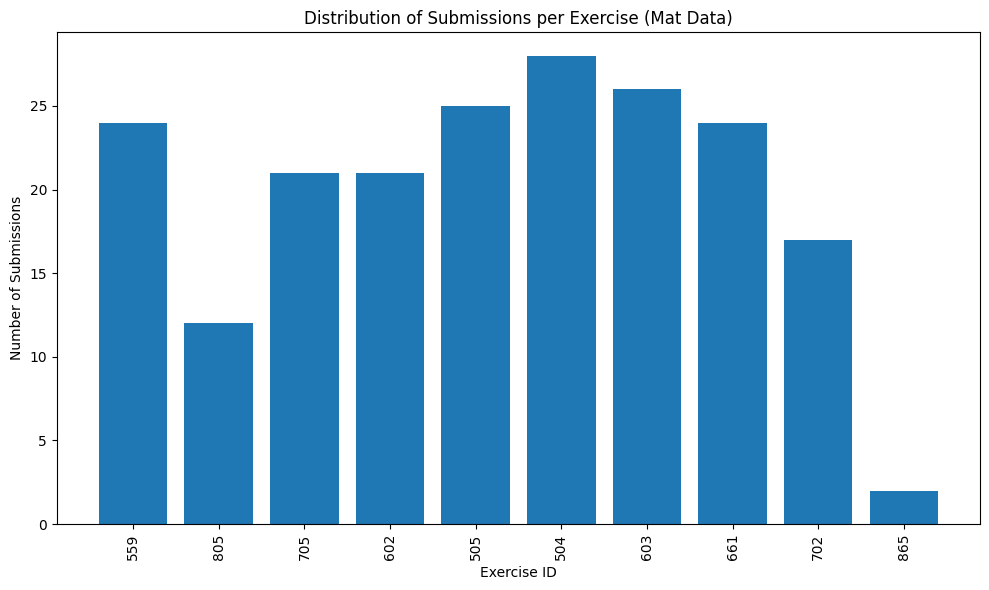


Summary statistics for submissions per exercise (Stat):
count    10.000000
mean     20.000000
std      12.866839
min       9.000000
25%       9.500000
50%      16.500000
75%      24.250000
max      48.000000
Name: Submissions, dtype: float64

Summary statistics for submissions per exercise (Mat):
count    10.000000
mean     20.000000
std       7.859884
min       2.000000
25%      18.000000
50%      22.500000
75%      24.750000
max      28.000000
Name: Submissions, dtype: float64
Unique exercises in Stat set: 10
Unique exercises in Mat set: 10


In [6]:
import matplotlib.pyplot as plt
import pandas as pd
from helpers.stratified_sample import stratified_random_sample

# Combine submissions and tasks into one dataset
combined_data = submissions_df.merge(tasks_df, left_on="task_id", right_on="id")

# Rename columns for consistent field names
combined_data.rename(columns={"max_points": "maxPoints"}, inplace=True)

# Convert to a list of dictionaries for stratified sampling
combined_data_dict = combined_data.to_dict(orient="records")

# Apply stratified sampling
sampled_data_by_course = stratified_random_sample(
    combined_data_dict,
    sample_size=400,  # Adjust as needed
    num_groups=6,
    exercise_sample_size=10  # Ensure diversity in exercises
)

# Separate sampled data into stat and mat
evaluation_data_stat_stratified = sampled_data_by_course.get("fs24-sta120", [])
evaluation_data_mat_stratified = sampled_data_by_course.get("fs24-mat183", [])

# Check stratified sampling results
def count_submissions_by_exercise(data):
    counts = {}
    for entry in data:
        task_id = entry["task_id"]
        counts[task_id] = counts.get(task_id, 0) + 1
    return counts

# Count submissions per exercise for each course
counts_stat = count_submissions_by_exercise(evaluation_data_stat_stratified)
counts_mat = count_submissions_by_exercise(evaluation_data_mat_stratified)

# Count unique exercises
unique_exercises_stat = len(counts_stat)
unique_exercises_mat = len(counts_mat)

print(f"Total sampled submissions (Stat): {len(evaluation_data_stat_stratified)}")
print(f"Total unique exercises (Stat): {unique_exercises_stat}")
print(f"Total sampled submissions (Mat): {len(evaluation_data_mat_stratified)}")
print(f"Total unique exercises (Mat): {unique_exercises_mat}")

# Convert counts to DataFrames for visualization
counts_stat_df = pd.DataFrame(list(counts_stat.items()), columns=["Exercise", "Submissions"])
counts_mat_df = pd.DataFrame(list(counts_mat.items()), columns=["Exercise", "Submissions"])

# Plot the distribution of submissions per exercise for each course
def plot_submissions_distribution(df, title):
    plt.figure(figsize=(10, 6))
    plt.bar(df["Exercise"].astype(str), df["Submissions"])
    plt.xlabel("Exercise ID")
    plt.ylabel("Number of Submissions")
    plt.title(title)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

plot_submissions_distribution(counts_stat_df, "Distribution of Submissions per Exercise (Stat Data)")
plot_submissions_distribution(counts_mat_df, "Distribution of Submissions per Exercise (Mat Data)")

# Summary statistics for submissions per exercise
summary_stats_stat = counts_stat_df["Submissions"].describe()
summary_stats_mat = counts_mat_df["Submissions"].describe()

print("\nSummary statistics for submissions per exercise (Stat):")
print(summary_stats_stat)

print("\nSummary statistics for submissions per exercise (Mat):")
print(summary_stats_mat)

# Final integrity checks
print(f"Unique exercises in Stat set: {len(set(d['task_id'] for d in evaluation_data_stat_stratified))}")
print(f"Unique exercises in Mat set: {len(set(d['task_id'] for d in evaluation_data_mat_stratified))}")


### Check the data

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

# Check number of unique exercises
unique_exercises_stat = len(set(d["task_id"] for d in evaluation_data_stat_stratified))
unique_exercises_mat = len(set(d["task_id"] for d in evaluation_data_mat_stratified))

print(f"Total exercises in Stat set: {unique_exercises_stat}")
print(f"Total exercises in Mat set: {unique_exercises_mat}")

# Count submissions per exercise for each dataset
def count_submissions_by_exercise(data):
    counts = {}
    for entry in data:
        task_id = entry["task_id"]
        counts[task_id] = counts.get(task_id, 0) + 1
    return counts

counts_stat = count_submissions_by_exercise(evaluation_data_stat_stratified)
counts_mat = count_submissions_by_exercise(evaluation_data_mat_stratified)

# Convert counts to DataFrame for visualization
df_stat = pd.DataFrame(list(counts_stat.items()), columns=["Exercise", "Submissions"])
df_mat = pd.DataFrame(list(counts_mat.items()), columns=["Exercise", "Submissions"])

# Plot distribution of submissions per exercise
def plot_submissions_distribution(df, title):
    plt.figure(figsize=(10, 6))
    plt.bar(df["Exercise"].astype(str), df["Submissions"])
    plt.xlabel("Exercise ID")
    plt.ylabel("Number of Submissions")
    plt.title(title)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

plot_submissions_distribution(df_stat, "Distribution of Submissions per Exercise (Stat Set)")
plot_submissions_distribution(df_mat, "Distribution of Submissions per Exercise (Mat Set)")

# Summary statistics for submissions per exercise
stat_summary = df_stat["Submissions"].describe()
mat_summary = df_mat["Submissions"].describe()

print("Stat Submissions per Exercise Summary:")
print(stat_summary)

print("\nMat Submissions per Exercise Summary:")
print(mat_summary)


KeyError: 'task_id'

In [3]:
# Prepare the evaluation data
evaluation_data_stat = []
evaluation_data_mat = []
for _, submission in submissions_df.iterrows():
    course = tasks_df.loc[tasks_df['id'] == submission['task_id'], 'course_slug'].values[0]
    if course == "fs24-sta120":
        evaluation_data_stat.append({
            "question": tasks_df.loc[tasks_df['id'] == submission['task_id'], 'instruction'].values[0], # Get the question from the tasks_df using the task_id in the submissions_df
            "answer":  submission['content'],
            "modelSolution": tasks_df.loc[tasks_df['id'] == submission['task_id'], 'solution'].values[0],
            "maxPoints": tasks_df.loc[tasks_df['id'] == submission['task_id'], 'max_points'].values[0],
            "minPoints": 0,  # Default minPoints
            "pointStep": 0.5,  # Default pointStep
            "human_points": submission['points']
        })
    elif course == "fs24-mat183":
        evaluation_data_mat.append({
            "question": tasks_df.loc[tasks_df['id'] == submission['task_id'], 'instruction'].values[0], # Get the question from the tasks_df using the task_id in the submissions_df
            "answer":  submission['content'],
            "modelSolution": tasks_df.loc[tasks_df['id'] == submission['task_id'], 'solution'].values[0],
            "maxPoints": tasks_df.loc[tasks_df['id'] == submission['task_id'], 'max_points'].values[0],
            "minPoints": 0,  # Default minPoints
            "pointStep": 0.5,  # Default pointStep
            "human_points": submission['points']
        })
    else:
        print(f"Unknown course_slug: {course}")
    

In [4]:
print(evaluation_data_stat[:5])
print(evaluation_data_mat[:5])
print(f"Total submissions to evaluate: {len(evaluation_data_stat)}")
print(f"Total submissions to evaluate: {len(evaluation_data_mat)}")

[{'question': "The dataset Oral is available in the R package spam and contains oral cavity cancer counts for $544$ districts in Germany.\nSimulate a 95\\% confidence interval for the sample mean of the variable SRM based on the following bootstrap scheme (sampling with replacement):\nRepeat $10'000$ times\n    - Sample $544$ observations $Z_{i}$ with replacement\\\n    - Calculate and store the mean of these sampled observations\\\nConstruct the confidence interval by taking the 2.5\\% and the 97.5\\% quantiles of the stored means.\n", 'answer': 'require(spam)\ndata(Oral)\n\nn <- 544\nset.seed(3)\n\n# Room for creativity!\nboot_means <- replicate(10000, {\n  sampled_indices <- sample(1:n, replace = TRUE)\n  mean(Oral$q[sampled_indices])\n})\n\nsol <- quantile(boot_means, c(0.025, 0.975), na.rm = TRUE)\n', 'modelSolution': 'require(spam) \ndata(Oral) \nn <- 544\nmybootstrap <- function(n.replications){ \n temporary <- array(0, dim = n.replications) # Preallocation is always advisable! 

# Evaluation
We use parallelism here to speed up the evaluation process. We evaluate the submissions using the LLM and compare the results with the human-assigned points.

In [72]:
import copy
import requests
from tqdm.notebook import tqdm

# Function to evaluate the submissions using the LLM
def evaluate(to_evaluate, solution=False, cot=False, voting=1):
    EVALUATION_URL = "http://localhost:4000/evaluate"
    tracker = []
    accuracy_tracker = []
    logs = []

    def calculate_accuracy(human_points, llm_points, max_points):
        if max_points == 0:
            return 1  # Avoid division by zero
        diff = abs(human_points - llm_points)
        return 1 - diff / max_points

    for idx, submission in enumerate(tqdm(to_evaluate, desc="Evaluating submissions"), start=1):
        try:
            # Prepare payload for the API
            payload = prepare_payload(submission, solution=solution, cot=cot, voting=voting)
            # Make API call for evaluation
            response = requests.post(EVALUATION_URL, json=payload, headers={"Content-Type": "application/json"})
            response.raise_for_status()
            evaluation_result = response.json()

            # Extract LLM-assigned points and rubric data
            llm_points = evaluation_result.get("points", 0)
            max_points = payload["maxPoints"]
            human_points = submission.get("human_points", 0)

            # Calculate accuracy
            accuracy = calculate_accuracy(human_points, llm_points, max_points)

            tracker.append({
                "human_points": human_points,
                "gpt_points": llm_points,
                "accuracy": accuracy,
                "evaluation_result": evaluation_result,
                "submission": submission,  # Store the original submission
            })
            accuracy_tracker.append(accuracy)

            # Add logs
            logs.append(f"Submission {idx} Result: {evaluation_result}")
            logs.append(f"Human Points: {human_points}, GPT Points: {llm_points}")
            logs.append(f"Accuracy: {accuracy:.2%}")
        except requests.exceptions.RequestException as e:
            print(f"Error evaluating submission {idx}: {e}")
            logs.append(f"Error evaluating submission {idx}: {e}")

    average_accuracy = sum(accuracy_tracker) / len(accuracy_tracker) if accuracy_tracker else 0

    return tracker, average_accuracy, logs


def prepare_payload(submission, solution=False, cot=False, voting=1):
    # Create a deep copy to avoid modifying the original
    submission_copy = copy.deepcopy(submission)

    # Ensure required fields exist with default values
    submission_copy.setdefault("rubrics", [])
    submission_copy.setdefault("modelSolution", "")
    submission_copy.setdefault("temperature", 0)
    submission_copy.setdefault("llmType", "gpt")

    # Adjust optional fields
    if not solution:
        submission_copy.pop("modelSolution", None)
        submission_copy.pop("rubrics", None)  # Remove rubrics if not using solution

    # Add chain of thought and voting parameters
    submission_copy["chainOfThought"] = cot
    submission_copy["votingCount"] = voting

    # Convert np.float64 to float for numeric fields
    submission_copy["maxPoints"] = float(submission_copy.get("maxPoints", 0))
    submission_copy["minPoints"] = float(submission_copy.get("minPoints", 0))
    submission_copy["pointStep"] = float(submission_copy.get("pointStep", 0))

    return {
        "question": submission_copy["question"],
        "answer": submission_copy["answer"],
        "rubrics": submission_copy.get("rubrics", []),
        "modelSolution": submission_copy.get("modelSolution", "Undefined"),
        "maxPoints": submission_copy["maxPoints"],
        "minPoints": submission_copy["minPoints"],
        "pointStep": submission_copy["pointStep"],
        "temperature": 0,
        "llmType": "gpt",
        "chainOfThought": cot,
        "votingCount": voting,
    }


## Setup

In [59]:
from helpers.parallel_evaluate import parallel_evaluate

# Parallel evaluation setup
num_threads = 4  # Adjust based on your CPU cores, keep it at max 4 due to rate limits.
batch_size = 25

# Sample size for evaluation in total
sample_size = 100

# Number of groups for stratified sampling, the more groups the more well distributed the sample. Generally this should increase with the sample size
num_groups = 6

## Stratified Sampling

In [60]:
from helpers.stratified_sample import stratified_random_sample

# Get well distributed sample (assuming maxPoints = roughly difficulty)
evaluation_data_stat_rand = stratified_random_sample(evaluation_data_stat, sample_size=sample_size, num_groups=num_groups)

# evaluate random stratified subset of mat
evaluation_data_mat_rand = stratified_random_sample(evaluation_data_mat, sample_size=sample_size, num_groups=num_groups)


## Evaluate each case
We evaluate the submissions using different strategies to see how they affect the accuracy of the LLM.

### Without Voting, CoT and Solutions
This represents the most basic evaluation setup, accuracy should be lowest here.


In [61]:
# evaluate random subset of stat without including solutions
stat_tracker_no_solutions, stat_accuracy_no_solutions, stat_logs_no_solutions = parallel_evaluate(
    evaluation_data_stat_rand, func=evaluate, num_threads=num_threads, batch_size=batch_size
)

print(f"Satistics Set: Average Accuracy without any strategiesy-y: {stat_accuracy_no_solutions:.2%}")


Evaluating batch...Evaluating batch...

Evaluating batch...
Evaluating batch...


Evaluating submissions:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating submissions:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating submissions:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating submissions:   0%|          | 0/25 [00:00<?, ?it/s]

Satistics Set: Average Accuracy without any strategies: 70.00%


In [62]:
mat_tracker_no_solutions, mat_accuracy_no_solutions, mat_logs_no_solutions = parallel_evaluate(evaluation_data_mat_rand, func=evaluate, num_threads=num_threads, batch_size=batch_size)
print(f"Maths Set: Average Accuracy without any strategies: {mat_accuracy_no_solutions:.2%}")


Evaluating batch...Evaluating batch...

Evaluating batch...
Evaluating batch...


Evaluating submissions:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating submissions:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating submissions:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating submissions:   0%|          | 0/25 [00:00<?, ?it/s]

Maths Set: Average Accuracy without any strategies: 72.50%


### With Solutions
We add the solutions to the evaluation data to see how it affects the accuracy of the LLM.

In [69]:

stat_tracker, stat_accuracy, stat_logs = parallel_evaluate(evaluation_data_stat_rand, func=evaluate, num_threads=num_threads, batch_size=batch_size, solution=True)
print(f"Statistics Set: Average Accuracy with added solutions: {stat_accuracy:.2%}")


Evaluating batch...Evaluating batch...

Evaluating batch...
Evaluating batch...


Evaluating submissions:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating submissions:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating submissions:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating submissions:   0%|          | 0/25 [00:00<?, ?it/s]

{'question': "In a simple linear regression, the data are assumed to follow $Y_i = \\beta_0 + \\beta_1 x_i  + \\varepsilon_i$ with $\\varepsilon_i \\underset{iid}{\\sim} \\mathcal{N}(0, \\sigma^2)$, $i = 1, \\dots, n$. \nWe simulate $n = 15$ data points from that model with $\\beta_0 = 1$, $\\beta_1 = 2$, $\\sigma = 2$ and the following values for $x_i$.\n\nPlot the simulated data in a scatter plot in your Rstudio. Calculate the Pearson correlation coefficient and the Spearman's rank correlation coefficient. Why do they agree well? \n\nEstimate the linear regression coefficients $\\widehat{\\beta_0}$ and $\\widehat{\\beta_1}$ using the formulas from the script. \n\n*PS* -  The same code will repeat multiple time during this exercise. We recommend you to copy your final code and save it somewhere for the next exercise.\n", 'answer': '# use the following code as a base:\nset.seed(5)         ## for reproducible simulations \nbeta0.true <- 1    ## true parameters, intercept\nbeta1.true <- 

In [70]:
mat_tracker, mat_accuracy, mat_logs = parallel_evaluate(evaluation_data_mat_rand, func=evaluate, num_threads=num_threads, batch_size=batch_size, solution=True)
print(f"Maths Set: Average Accuracy with added solutions: {mat_accuracy:.2%}")

Evaluating batch...
Evaluating batch...
Evaluating batch...
Evaluating batch...


Evaluating submissions:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating submissions:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating submissions:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating submissions:   0%|          | 0/25 [00:00<?, ?it/s]

{'question': "The sum of two independent normally distributed random variables is another normally distributed random variable. We will visualize this with some normally distributed samples. To this end, generate two samples, each with size $3000$, of the form\n\n* $X\\sim N(65, 30)$,\n\n* $Y\\sim N(35, 11)$,\n\nwhere (unlike in R!) the second parameter we list is the variance, i.e. $N(\\mu, \\sigma^2)$.\nAdd these two samples to generate a single sample $V$. To check if $V$ is also normally distributed, use a quantile-quantile-plot and a histogram. Don't forget to write down what you conclude!\n\nTip: Do you still remember the functions $hist()$, $qqnorm()$, and $qqline()$?\n\n", 'answer': 'png(file = "solution.png")\nset.seed(10) #um reproduzierbar zu arbeiten\npar(mfrow=c(1,2)) # 2 Plots nebeneinander\n\nX <- rnorm(3000, mean = 65, sd = sqrt(30)) # sd = sqrt(Var) \nY <- rnorm(3000, mean = 35, sd = sqrt(11))\nV <- X+Y\n\n#Quantil-Quantil-Plot\nqqnorm(V, pch=16, col="orange")\nqqline(

### With Solutions and Voting
Here we add voting, meaning we evaluate the submissions multiple times and take the average of the points assigned by the LLM. This happens in the backend.

In [73]:
num_threads = 2 # Due to rate limits and voting making more calls, we reduce the number of threads
stat_tracker_voting, stat_accuracy_voting, stat_logs_voting = parallel_evaluate(evaluation_data_stat_rand, func=evaluate, num_threads=num_threads, batch_size=batch_size, solution=True, voting=3)
print(f"Statistics Set: Average Accuracy with added solutions and voting: {stat_accuracy_voting:.2%}")


Evaluating batch...
Evaluating batch...
Evaluating batch...
Evaluating batch...


Evaluating submissions:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating submissions:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating submissions:   0%|          | 0/25 [00:00<?, ?it/s]

Evaluating submissions:   0%|          | 0/25 [00:00<?, ?it/s]

Error evaluating submission 9: 500 Server Error: Internal Server Error for url: http://localhost:4000/evaluate
Error evaluating submission 8: 500 Server Error: Internal Server Error for url: http://localhost:4000/evaluate
Error evaluating submission 10: 500 Server Error: Internal Server Error for url: http://localhost:4000/evaluate
Error evaluating submission 9: 500 Server Error: Internal Server Error for url: http://localhost:4000/evaluate
Error evaluating submission 9: 500 Server Error: Internal Server Error for url: http://localhost:4000/evaluate
Error evaluating submission 10: 500 Server Error: Internal Server Error for url: http://localhost:4000/evaluate
Error evaluating submission 11: 500 Server Error: Internal Server Error for url: http://localhost:4000/evaluate
Error evaluating submission 11: 500 Server Error: Internal Server Error for url: http://localhost:4000/evaluate
Error evaluating submission 12: 500 Server Error: Internal Server Error for url: http://localhost:4000/evalu

In [ ]:
mat_tracker_voting, mat_accuracy_voting, mat_logs_voting = parallel_evaluate(evaluation_data_mat_rand, func=evaluate, num_threads=num_threads, batch_size=batch_size, solution=True, voting=3)
print(f"Maths Set: Average Accuracy with added solutions: {mat_accuracy_voting:.2%}")

### With Solutions, Voting and CoT

In [ ]:
stat_tracker_cot, stat_accuracy_cot, stat_logs_cot = parallel_evaluate(evaluation_data_stat_rand, func=evaluate, num_threads=num_threads, batch_size=batch_size, solution=True, voting=3, cot=True)
print(f"Statistics Set: Average Accuracy with solutions, voting and CoT: {stat_accuracy_cot:.2%}")

In [ ]:
mat_tracker_cot, mat_accuracy_cot, mat_logs_cot = parallel_evaluate(evaluation_data_mat_rand, func=evaluate, num_threads=num_threads, batch_size=batch_size, solution=True, voting=3, cot=True)
print(f"Maths Set: Average Accuracy with solutions, voting and CoT: {mat_accuracy_cot:.2%}")

## Clean and save the results

In [ ]:
from helpers.get_metrics import get_average_accuracy

# Clean data and recalculate the average accuracies in case of any missing data
average_mat_no_solution_accuracy, _ = get_average_accuracy(mat_tracker_no_solutions)
print(f"Average Accuracy Statistics cleaned: {average_mat_no_solution_accuracy:.2%}")

average_stat_no_solution_accuracy, _ = get_average_accuracy(stat_tracker_no_solutions)
print(f"Average Accuracy Statistics without solution cleaned: {average_stat_no_solution_accuracy:.2%}")

average_stat_accuracy, _ = get_average_accuracy(stat_tracker)
print(f"Average Accuracy Statistics with solution cleaned: {average_stat_accuracy:.2%}")

average_mat_accuracy, _ = get_average_accuracy(mat_tracker)
print(f"Average Accuracy Maths with solution cleaned: {average_mat_accuracy:.2%}")

average_stat_accuracy_voting, _ = get_average_accuracy(stat_tracker_voting)
print(f"Average Accuracy Statistics with solution and voting cleaned: {average_stat_accuracy_voting:.2%}")

average_mat_accuracy_voting, _ = get_average_accuracy(mat_tracker_voting)
print(f"Average Accuracy Maths with solution and voting cleaned: {average_mat_accuracy_voting:.2%}")

average_stat_accuracy_cot, _ = get_average_accuracy(stat_tracker_cot)
print(f"Average Accuracy Statistics with solution, voting and CoT cleaned: {average_stat_accuracy_cot:.2%}")

average_mat_accuracy_cot, _ = get_average_accuracy(mat_tracker_cot)
print(f"Average Accuracy Maths with solution, voting and CoT cleaned: {average_mat_accuracy_cot:.2%}")


In [ ]:
from helpers.save_results import save_evaluation_result_with_versioning

save_evaluation_result_with_versioning(stat_tracker_no_solutions, 'stat_evaluation_no_solutions_result.csv', 'results')
save_evaluation_result_with_versioning(mat_tracker_no_solutions, 'mat_evaluation_no_solutions_result.csv', 'results')

save_evaluation_result_with_versioning(stat_tracker, 'stat_evaluation_result.csv', 'results')
save_evaluation_result_with_versioning(mat_tracker, 'mat_evaluation_result.csv', 'results')

save_evaluation_result_with_versioning(stat_tracker_voting, 'stat_evaluation_voting_result.csv', 'results')
save_evaluation_result_with_versioning(mat_tracker_voting, 'mat_evaluation_voting_result.csv', 'results')

save_evaluation_result_with_versioning(stat_tracker_voting, 'stat_evaluation_voting_cot_result.csv', 'results')
save_evaluation_result_with_versioning(mat_tracker_voting, 'mat_evaluation_voting_cot_result.csv', 'results')

